# 0. Load dependencies and data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from interstellar import *
import warnings
from scipy.optimize import curve_fit

import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42


task_colors = {'perception': 'teal', 'wm': 'green', 'ltm': 'orange'}


warnings.filterwarnings('ignore')
wlsubjects = [114, 115, 127, 135, 136, 139, 141, 142]

# Set path to dataframe directory
df_dir = "../../data/dataframes/"

TS = pd.read_csv(os.path.join(df_dir, 'interstellar_TTA_fitparams.tsv'), sep = '\t', index_col = 0)

In [2]:
TTA_norm = pd.read_csv(os.path.join(df_dir, "sub-all_TTA_norm_bs10.tsv"), sep = '\t', index_col = 0)
roi_labels = ["V1", "V2", "V3", "V4", "V3ab", "IPS0", "LO1"]
rois = ["V1", "V2", "V3", "V4", "LO1", "V3ab", "IPS0"]

TTA_norm['roi_labels'] = [roi_labels[int(l-1)] for l in TTA_norm.roi.values]
# boot_fits['roi_labels'] = [roi_labels[int(l-1)] for l in boot_fits.roi.values]
conf_interval = [16, 84]
DVM = pd.DataFrame()

In [3]:
DVM_fname = os.path.join(df_dir, "interstellar_TTA_fitparams.tsv")
DVM = pd.read_csv(DVM_fname, sep = '\t', index_col = 0)

# 1. Figure 5a
- Load normalized Trial Triggered Average data (above)
- Fit Difference of Von Mises to each time point (loaded above, coded below)
- Plot a 2D heatmap (Time x Polar Angle Distance from target) for each condition and visual field map
- Plot a line for FWHM estimates over time. Symmetric over the 0° target line.


The below block of code may be ran if you wish to compute the fits yourself ('DVM'). Otherwise, they are loaded in the cell above by default. 


In [4]:
if DVM.empty:
    backpad = 0
    windowwidth = 15
    bin_size = 10

    tr_start = 0
    tr_stop = windowwidth + backpad
    pts = 361

    trs = np.asarray([str(i)+'_adj' for i in range(tr_start, tr_stop)])
    unique_tasks = np.asarray(['perception', 'ltm', 'wm'])
    rois_nums = np.asarray([1, 2, 3, 4, 5, 6, 7])

    theta_range = np.linspace(-np.pi, np.pi, pts)


    amps = {}
    locs = {}
    FDVM = []
    VM = np.zeros([361, len(trs), len(unique_tasks), len(rois_nums)])

    for tr, task, roi in itertools.product(trs, unique_tasks, rois_nums):
        task_idx = np.where(unique_tasks == task)[0][0]
        tr_idx = np.where(trs == tr)[0][0]
        roi_idx = np.where(rois_nums == roi)[0][0]

        data = TTA_norm.query('task == "%s" & roi == %d' % (task, roi))

        fdv = fit_diff_vonmises(data, tr)
        fdv['tr'] = tr_idx
        dvm = diff_vonmises(theta_range, fdv['loc'][0], fdv.kappa1[0], fdv.scale1[0], fdv.kappa2[0], fdv.scale2[0])

        FDVM.append(fdv)

        VM[:, tr_idx, task_idx, roi_idx] = dvm

        # fwhm, _, _, _ = sp.peak_widths(dvm, np.where(dvm == dvm.max())[0])

    DVM = pd.concat(FDVM, axis = 0)
    DVM = DVM.sort_values(['roi', 'task'])
    DVM['roi_labels'] = [roi_labels[int(l-1)] for l in DVM.roi.values]

    DVM_fname = os.path.join(df_dir, "interstellar_TTA_fitparams.tsv")
    DVM.to_csv(DVM_fname, sep = '\t')

The cell below uses a custom plotting function 'plot_TTA' to plot all the 2D TTA heatmaps & some custom aesthetics. See interstellar.py for 'plot_TTA' code.

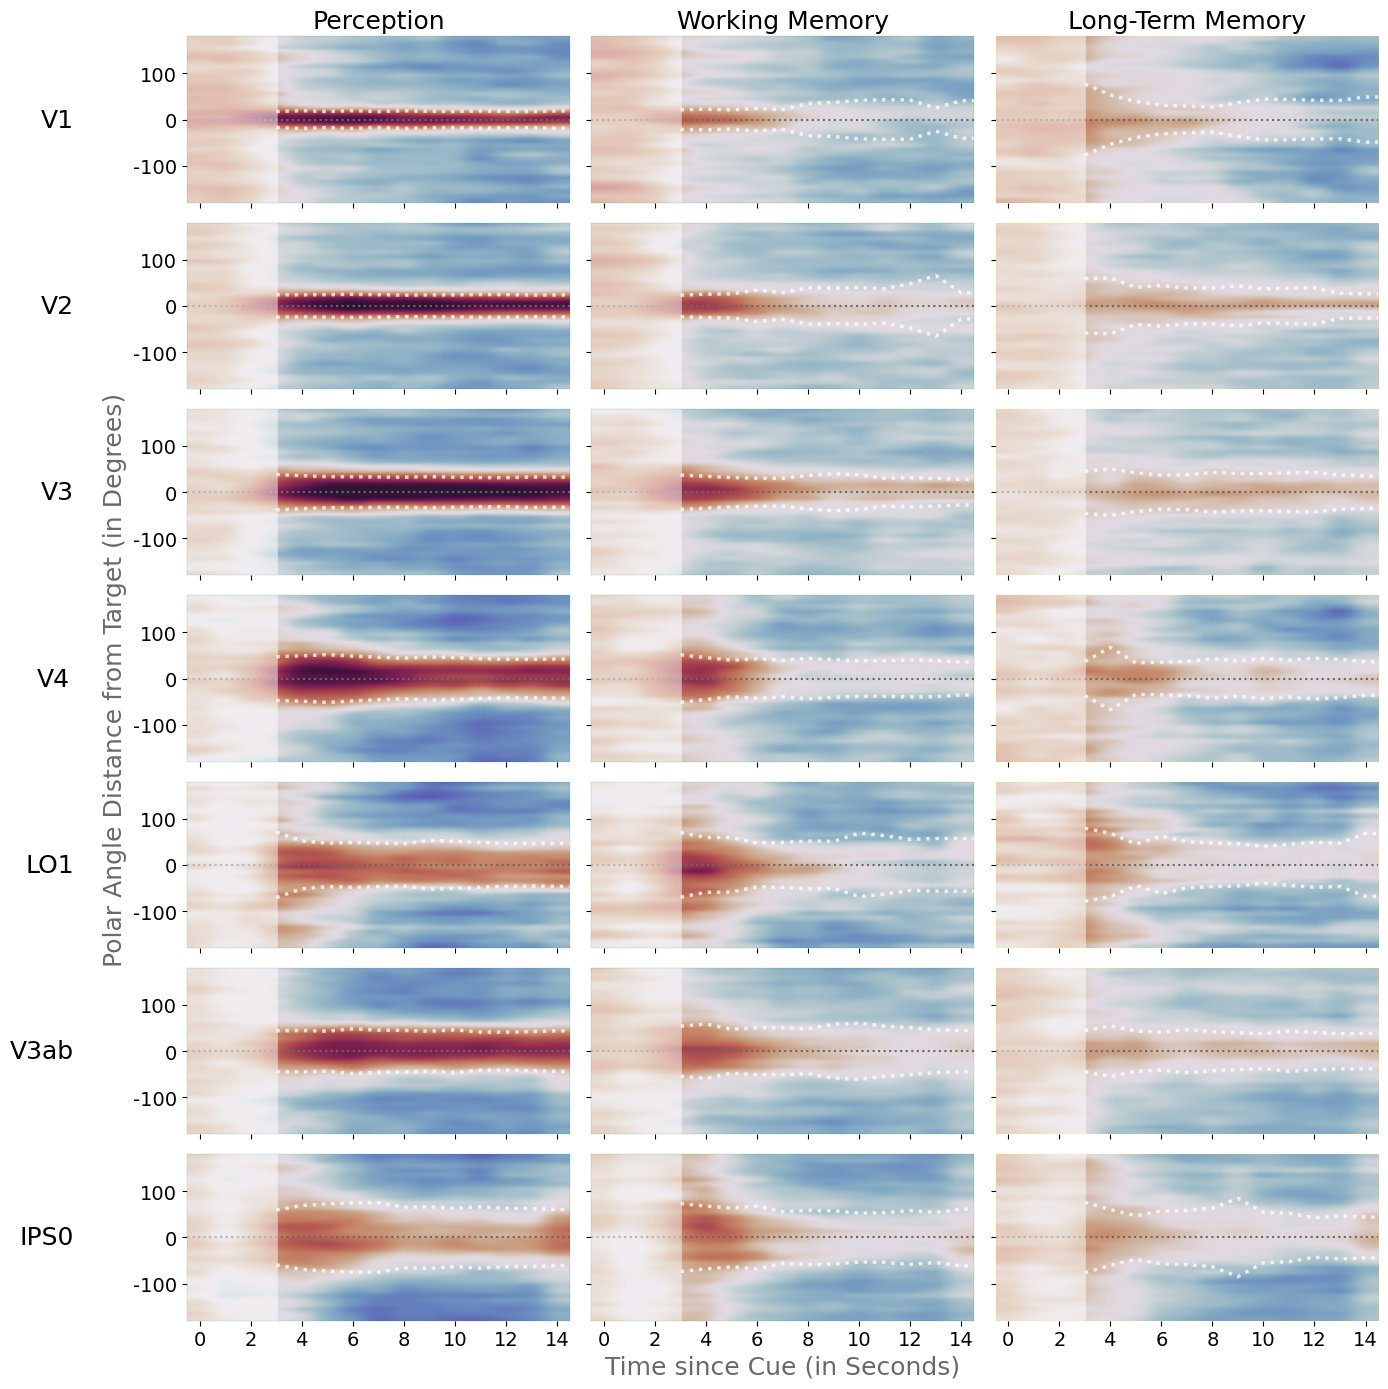

In [15]:
colors = {
    'perception': 'teal',
    'ltm':'gold',
    'wm':'green'
}

ttaplot_fname = "paper_figures/results_fig3_tta-heatmaps.pdf"

plot_TTA(TTA_norm, 
         order = {
             'tasks': ['perception', 'wm', 'ltm'],
             'rois': rois
         }, 
         figsize=(14,14), fits = DVM,
         interpolation = 'gaussian', start = 3, pad = 20, center = True)

# 2. Figure 5b
- Fit logistic functions to amplitude estimate timeseries data.
- Fit logistic functions to bootstrapped amplitude estimate tieseries data.
- Compute confidence intervals based on bootstrapped logistic fits
- Plot logistic fits & 68% confidence intervals

The below cell loads the amplitude estimate timeseries data for each roi & condition, and then fits a logistic function to the perception and long-term memory conditions. A multiplication of two logistic functions is fit to the working memory timeseries to account for the initial transient response due to the brief presentation of the target at the beginning of the delay period. 

See interstellar.py for the custom functions 'logistic', 'logistic2', and 'rise_time'.

In [6]:
P = []
t = np.linspace(0, 14, 10000)
sat = 0.90
for roi, task in itertools.product(TS.roi_labels.unique(), TS.task.unique()):
    ts = TS.query("roi_labels == @roi & task == @task")
    x = ts.tr.values
    y = ts.amp.values

    if task == 'wm':
        params, _ = curve_fit(logistic2, x, y, bounds = (
            (0, 0, 0, 0, -np.inf, 0, 0),
            (np.inf, 5, 15, np.inf, 0, 15, np.inf)
        ))
        y = logistic2(t, *params)
        p = [roi, task, *params]
    else:
        params, _ = curve_fit(logistic, x, y, bounds = (
            (0, 0, 0, 0),
            (np.inf, 5, 15, np.inf)
        ))
        y = logistic(t, *params)
        p = [roi, task, *params, '', '', '']

    risetime = rise_time(t, y, 0, sat)
    risetime_l = rise_time(t, y, start = 0.0, stop = sat, max = params[0])
    p.append(risetime)
    p.append(risetime_l)

    P.append(p)

P = pd.DataFrame(P, columns = ['roi', 'task', 'l', 'k', 'x0', 'c', 'k2', 'x2', 'c2', 'risetime', 'risetime_l'])
    



Load bootstrapped data

In [7]:
TS_boots = pd.read_csv(os.path.join(df_dir, 'interstellar_TTA_bootfits_500_V1-LO1.tsv'), sep = '\t', index_col = 0)
roi_labels = ["V1", "V2", "V3", "V4", "V3ab", "IPS0", "LO1"]
trs = np.tile(np.repeat(np.arange(15), 315/15), 500) # 315 = nrois * ntasks * ntrs
TS_boots['tr'] = trs
TS_boots['roi_labels'] = [roi_labels[int(l-1)] for l in TS_boots.roi.values]
TS_boots
TS_boots = TS_boots.replace([np.inf, -np.inf], np.nan)
B_norm = pd.DataFrame()
err = []


The below cell loads normalized boot fits. Skip this cell if you want to compute the boot fits from the boostrapped timeseries itself.

In [8]:
B_norm = pd.read_csv(os.path.join(df_dir, "boot_norm.tsv"), sep = '\t', index_col=0)

The cell below computes the nomralized bootstrapped fits if they haven't already been loaded by the cell above.

In [9]:
if  B_norm.empty:
    for boot, roi, task in itertools.product(TS_boots.n_boot.unique(), TS_boots.roi_labels.unique(), TS_boots.task.unique()):
        ts = TS_boots.query("roi_labels == @roi & task == @task & n_boot == @boot")
        x = ts.tr.values
        y = ts.amp.values
        
        try:
            if task == 'wm':
                params, _ = curve_fit(logistic2, x, y, bounds = (
                    (0, 0, 0, 0, -np.inf, 0, 0),
                    (np.inf, 5, 15, np.inf, 0, 15, np.inf)
                ))
                y = logistic2(t, *params)
                p = [roi, task, boot, *params]
            else:
                params, _ = curve_fit(logistic, x, y, bounds = (
                    (0, 0, 0, 0),
                    (np.inf, 5, 15, np.inf)
                ))
                y = logistic(t, *params)
                p = [roi, task, boot, *params, '', '', '']

            risetime = rise_time(t, y, start = 0.0, stop = sat)
            risetime_l = rise_time(t, y, start = 0.0, stop = sat, max = params[0])
            p.append(risetime)
            p.append(risetime_l)

            B_norm.append(p)
        except:
            err.append(boot)

    B_norm = pd.DataFrame(B_norm, columns = ['roi', 'task', 'n_boot', 'l', 'k', 'x0', 'c', 'k2', 'x2', 'c2', 'risetime', 'risetime_l'])


The cell below computes the upper and lower bounds of the confidence interval from the bootstrapped fits ('B_norm'), for each condition and visual map. 

In [10]:
tasks = ['perception', 'wm', 'ltm']
rois = ['V1', 'V2', 'V3', 'V4', 'LO1', 'V3ab', 'IPS0']
Y = np.zeros([len(tasks), len(rois), t.shape[0]])
CI_lower = np.zeros([len(tasks), len(rois), t.shape[0]])
CI_upper = np.zeros([len(tasks), len(rois), t.shape[0]])


for i, row in P.iterrows():

    col = rois.index(row.roi)

    color = task_colors[row.task]
    ts = TS.query("roi_labels == @row.roi & task == @row.task")

    if row.task == 'wm':
        params = [*row.values[2:9]]
        y = logistic2(t, *params)

    else:
        params = [*row.values[2:6]]
        y = logistic(t, *params)

    err_bands, err_bands_ts = boot_errbands(row.roi, row.task, B_norm, TS_boots, t)
    Y[tasks.index(row.task), rois.index(row.roi), :] = y
    CI_lower[tasks.index(row.task), rois.index(row.roi), :] = err_bands[0, :]
    CI_upper[tasks.index(row.task), rois.index(row.roi), :] = err_bands[1, :]

The cell below plots the timeseries logistic fits and their 68% confidence intervals.

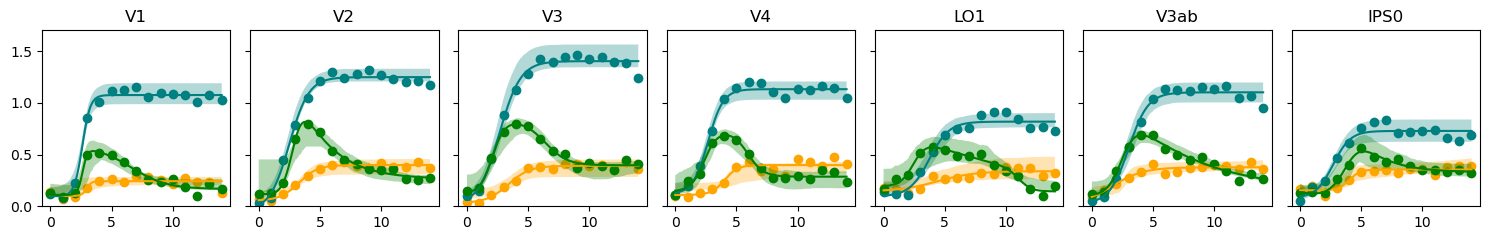

In [11]:
fig, axs = plt.subplots(1, 7, figsize = [15, 2.5], sharey = True)
ss_ = []
ss_upper_ci = []
ss_lower_ci = []
for i, row in P.iterrows():
    col = rois.index(row.roi)

    color = task_colors[row.task]
    ts = TS.query("roi_labels == @row.roi & task == @row.task")


    y = Y[tasks.index(row.task), rois.index(row.roi), :]
    lower_ci = CI_lower[tasks.index(row.task), rois.index(row.roi), :]
    upper_ci = CI_upper[tasks.index(row.task), rois.index(row.roi), :]


    y_ts = ts.amp.values
    data, errs = ss(y_ts, err_bands)
    ss_.append(data)
    ss_lower_ci.append(errs[0])
    ss_upper_ci.append(errs[1])

    axs[col].plot(t, y, c = color)

    axs[col].scatter(ts.tr.values, y_ts, c = color)

    axs[col].fill_between(t, lower_ci, upper_ci, facecolor=task_colors[row.task], alpha=0.3)
    axs[col].set_title("%s" % row.roi)
    axs[col].set_ylim([0, 1.7])

fig.tight_layout()
P['ss'] = ss_
P['ss_lower_ci'] = ss_lower_ci
P['ss_upper_ci'] = ss_upper_ci

# 3. Figure 5c
- Plot the above timeseries plots, but just the last ten seconds


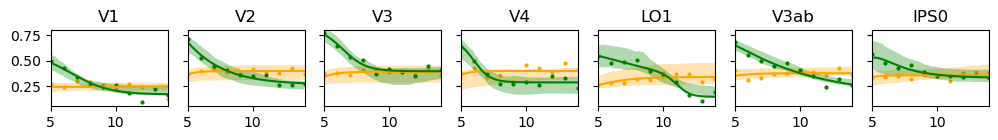

In [12]:
fig, axs = plt.subplots(1, 7, figsize = [10, 1.5], sharey = True)
rois = ['V1', 'V2', 'V3', 'V4', 'LO1', 'V3ab', 'IPS0']
ss_ = []
ss_upper_ci = []
ss_lower_ci = []

for i, row in P.iterrows():
    if row.task == 'perception': continue

    col = rois.index(row.roi)

    color = task_colors[row.task]
    ts = TS.query("roi_labels == @row.roi & task == @row.task")
    y_ts = ts.amp.values

    y = Y[tasks.index(row.task), rois.index(row.roi), :]
    lower_ci = CI_lower[tasks.index(row.task), rois.index(row.roi), :]
    upper_ci = CI_upper[tasks.index(row.task), rois.index(row.roi), :]
    
    

    axs[col].plot(t, y, c = color)

    axs[col].scatter(ts.tr.values, y_ts, c = color, s = 4)
    axs[col].fill_between(t, lower_ci, upper_ci, facecolor=task_colors[row.task], alpha=0.3)
    axs[col].set_title("%s" % row.roi)

    axs[col].set_ylim([0.05, .8])

    axs[col].set_xlim([5, 14])


fig.tight_layout()

# 4. Figure 5d
- Plot the time to x0 for each visual map and condition.
- x0 is the midpoint (or, more specifically, the inflection point) of the logistic fit

The cell below uses the x0 parameter from the 'logistic' function fits to show the rise-times for each condition and visual field map. 

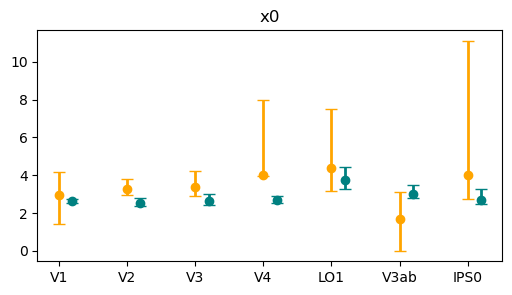

In [16]:
from matplotlib.transforms import Affine2D
fig, axs = plt.subplots(1, 1, figsize = [6, 3], sharey= False)

for i, task in enumerate(P.task.unique()):
    if task != 'wm':
        
        p = P.query("task == @task")
        b = B_norm.query("task == @task")
        b_err = compute_boot_err(b, 'roi', 'risetime')
        p = pd.merge(p, b_err, on = 'roi')


        x =np.asarray([rois.index(r) for r in p.roi.values])

        yvar = 'x0'
        p = P.query("task == @task")
        b = B_norm.query("task == @task")
        b_err = compute_boot_err(b, 'roi', yvar)
        p = pd.merge(p, b_err, on = 'roi')


        x =np.asarray([rois.index(r) for r in p.roi.values])
        axs.errorbar(x = x + (i*.2), y = p[yvar], yerr = [rect(p[yvar] - p.lower_ci), p.upper_ci - p[yvar]], 
                        c = task_colors[task], fmt = 'o', alpha = 1, capsize = 4, elinewidth = 2, capthick = 1, ms= 6)

        axs.set_xticks(np.arange(0, 7), rois)
        axs.set_title('x0')
